<a href="https://colab.research.google.com/github/Quotermain/sber_stock_analysis/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 1.4MB 5.8MB/s 
     |████████████████████████████████| 890kB 40.6MB/s 
     |████████████████████████████████| 2.9MB 44.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=3e9695b7550181c264ed7fcc682d10d8b324aefc7e636453587311e0d065d7a9
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from transformers import AutoTokenizer
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
import datetime

import pickle
  
import re

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


In [ ]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
  
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):

    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        '''Берём только те значения из предсказаний и истинных лейблов, 
        которые равны классу текущей итерации (фильтруем)'''
        y_preds = preds_flat[labels_flat==label] # Тут и ошибочные предсказания
        y_true = labels_flat[labels_flat==label] # Тут будут только истинные
        
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
"""
Сбрасываю временные индексы на обычную нумерацию, т.к. теперь это просто задача
классификации. Также сбрасываю ненужные колонки.
"""

merged = pd.read_csv(
    'drive/MyDrive/data/merged.csv',
    usecols=[1, 2]
)

print(merged.head(1))

   target                                            text
0       1  Азиатские биржевые индексы замедлили свой рост


In [ ]:
"""Encodes labels to nums to put those in a model"""
label_dict = {'up': 0, 'down': 1, 'nothing': 2}
label_dict

{'down': 1, 'nothing': 2, 'up': 0}

# Loading prices

In [ ]:
data = pd.read_csv(
    'drive/MyDrive/data/SBER.txt', 
    usecols=['<DATE>', '<TIME>', '<CLOSE>', '<HIGH>', '<LOW>'],
    parse_dates=[['<DATE>', '<TIME>']],
    dayfirst=True
)
data.columns = ['datetime', 'high', 'low',  'close']

data.head()

,datetime,high,low,close
0,2009-01-11 10:30:00,23.30,22.99,23.01
1,2009-01-11 10:31:00,23.08,22.98,23.02
2,2009-01-11 10:32:00,23.31,23.04,23.20
3,2009-01-11 10:33:00,23.30,23.19,23.22
4,2009-01-11 10:34:00,23.27,23.20,23.24


In [ ]:
RESAMPLE_PERIOD = '5min'

close = data.groupby(
    pd.Grouper(key='datetime', freq=RESAMPLE_PERIOD)
).mean().close

high = data.groupby(
    pd.Grouper(key='datetime', freq=RESAMPLE_PERIOD)
).max().high

low = data.groupby(
    pd.Grouper(key='datetime', freq=RESAMPLE_PERIOD)
).min().low

In [ ]:
'''
Создаём отдельный датафрейм с ретёрнами до максимума и до минимума следующей
свечи, чтобы потом выбрать максимум по модулю. Если максимум по модулю до лоу - 
down, если максимум по модулю до хай - up.
'''

data = {
  'returns_to_high': (high.shift(-1) - close) / close,
  'returns_to_low': (low.shift(-1) - close) / close
} 

returns = pd.DataFrame(
  data=data, index=close.index
)

returns.head()

,returns_to_high,returns_to_low
datetime,,
2009-01-11 10:30:00,0.004408,-0.004668
2009-01-11 10:35:00,0.001906,-0.001993
2009-01-11 10:40:00,0.004936,-0.001126
2009-01-11 10:45:00,0.008374,-0.001554
2009-01-11 10:50:00,0.009384,0.002497


In [ ]:
def max_return(x):
  if x.returns_to_high > abs(x.returns_to_low):
    return x.returns_to_high
  else:
    return x.returns_to_low

returns['target'] = returns.apply(max_return, axis=1)

returns.head(10)

,returns_to_high,returns_to_low,target
datetime,,,
2009-01-11 10:30:00,0.004408,-0.004668,-0.004668
2009-01-11 10:35:00,0.001906,-0.001993,-0.001993
2009-01-11 10:40:00,0.004936,-0.001126,0.004936
2009-01-11 10:45:00,0.008374,-0.001554,0.008374
2009-01-11 10:50:00,0.009384,0.002497,0.009384
2009-01-11 10:55:00,0.000599,-0.003682,-0.003682
2009-01-11 11:00:00,0.000429,-0.003431,-0.003431
2009-01-11 11:05:00,0.003263,-0.001460,0.003263
2009-01-11 11:10:00,-0.000086,-0.003090,-0.003090


In [ ]:
mean_returns = returns.target.mean()
mean_returns

-2.7472545660199215e-05

In [ ]:
std_returns = returns.target.std()
std_returns

0.0030154054445083217

In [ ]:
conditions = [
    returns.target > 0.0007,
    returns.target < -0.0007
]

choices = ["up", "down"]

returns['target'] = np.select(conditions, choices, default='nothing')

In [ ]:
returns.target.value_counts()

nothing    970007
down       137546
up         133887
Name: target, dtype: int64

# Working with news

#### Cleaning parsed news

In [ ]:
news = pd.read_csv('drive/MyDrive/data/full_news.csv')

news.head()

In [ ]:
"""
Cleanes the text column from HTML markup, source of news,
\n, \r, \t and excess spaces
"""

news.text = news.text.apply(
    lambda x: re.sub(
        '<[^<]+?>|\n|\r|\t|© Reuters.|Investing.com — |  +', '', x
    )
)


'''
Extracts date and time
'''
news.datetime = news.datetime.str.extract(
    r'(\d+\.\d+\.\d+ \d+:\d+)'
)

In [ ]:
news.to_csv(
    'drive/MyDrive/data/full_news_cleaned.csv', 
    index=False
)

#### Loading cleaned news

In [ ]:
news = pd.read_csv(
    'drive/MyDrive/data/full_news_cleaned.csv',
    dayfirst=True,
    parse_dates=True,
    #index_col='datetime',
    usecols=['datetime', 'title']
)

news.dropna(inplace=True)

news['datetime'] = pd.to_datetime(news.datetime)

news.tail()

,datetime,title
94851,2020-09-24 11:45:00,Суд арестовал имущество и счета бывших топ-мен...
94852,2020-09-24 18:00:00,"STOCKS-Рынок акций РФ закрывается в минусе, ли..."
94853,2020-09-24 17:09:00,Уолл-стрит снова в минорном настроении
94854,2020-09-23 08:22:00,Большинство европейских рынков акций завершило...
94855,2020-09-24 11:51:00,Сбер представил новую экосистему с виртуальным...


#### Resampling news

In [ ]:
def join(x):
  return ' '.join(x.values)

news = news.groupby(
    pd.Grouper(key='datetime', freq=RESAMPLE_PERIOD)
).agg({'title': join}).dropna()

news.title.replace('', np.nan, inplace=True)

news.dropna(inplace=True)

news.head()

,title
datetime,
2010-02-11 11:15:00,Азиатские биржевые индексы замедлили свой рост
2010-02-12 17:55:00,Американские акции выросли после выхода данных...
2010-04-10 11:50:00,Азиатские фондовые рынки продемонстрировали ра...
2010-04-11 11:30:00,Азиатские фондовые рынки резко поднялись после...
2010-06-09 11:05:00,Азиатские биржи в понедельник ушли в рост


# Merging prices and news

In [ ]:
merged = returns[['target']].merge(
    news, left_index=True, right_index=True
)

merged.columns = ['target', 'text']

merged.head()

,target,text
datetime,,
2010-02-11 11:15:00,down,Азиатские биржевые индексы замедлили свой рост
2010-02-12 17:55:00,down,Американские акции выросли после выхода данных...
2010-04-10 11:50:00,nothing,Азиатские фондовые рынки продемонстрировали ра...
2010-04-11 11:30:00,nothing,Азиатские фондовые рынки резко поднялись после...
2010-06-09 11:05:00,up,Азиатские биржи в понедельник ушли в рост


In [ ]:
merged.target.value_counts()

nothing    37027
down       16196
up         15617
Name: target, dtype: int64

In [ ]:
print('Merged data shape: ', merged.shape)
print('Num of "ups": ', len(merged[merged.target == 'up']))
print('Num of "downs": ', len(merged[merged.target == 'down']))
print('Num of "nothings": ', len(merged[merged.target == 'nothing']))

Merged data shape:  (68840, 2)
Num of "ups":  15617
Num of "downs":  16196
Num of "nothings":  37027


In [ ]:
merged['target'] = merged.target.replace(label_dict)
merged.head()

,target,text
datetime,,
2010-02-11 11:15:00,1,Азиатские биржевые индексы замедлили свой рост
2010-02-12 17:55:00,1,Американские акции выросли после выхода данных...
2010-04-10 11:50:00,2,Азиатские фондовые рынки продемонстрировали ра...
2010-04-11 11:30:00,2,Азиатские фондовые рынки резко поднялись после...
2010-06-09 11:05:00,0,Азиатские биржи в понедельник ушли в рост


In [ ]:
merged.to_csv(
    'drive/MyDrive/data/merged.csv'
)

#Text summarization

In [ ]:
pip install bert-extractive-summarizer

In [ ]:
from summarizer import Summarizer

model = Summarizer()

In [ ]:
merged.text = merged.text.apply(lambda x: model(x, num_sentences=25))

/usr/local/lib/python3.6/dist-packages/summarizer/cluster_features.py:106: ConvergenceWarning: Number of distinct clusters (19) found smaller than n_clusters (21). Possibly due to duplicate points in X.
  model = self.__get_model(k).fit(self.features)
/usr/local/lib/python3.6/dist-packages/summarizer/cluster_features.py:106: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  model = self.__get_model(k).fit(self.features)
/usr/local/lib/python3.6/dist-packages/summarizer/cluster_features.py:106: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  model = self.__get_model(k).fit(self.features)
/usr/local/lib/python3.6/dist-packages/summarizer/cluster_features.py:106: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  model = self.__get_model(k).fit(self.fe

In [ ]:
merged.to_csv('drive/MyDrive/data/whole_texts.csv')

In [ ]:
merged.text.str.split().apply(lambda x: len(x)).max()

# Splitting the merged data on train and test

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    merged.index.values, 
    merged.target.values, 
    test_size=0.1, 
    stratify=merged.target.values,
    random_state=1
)

for key, value in label_dict.items():
  print(
      f"Ratio of '{key}s' in val and train",
      len(y_val[y_val == value]) / len(y_train[y_train == value])
  )

Ratio of 'ups' in val and train 0.1111348274635361
Ratio of 'downs' in val and train 0.11106537696370995
Ratio of 'nothings' in val and train 0.11112111391189533


In [ ]:
np.savetxt('drive/MyDrive/data/whole_text/X_train.txt', X_train)
np.savetxt('drive/MyDrive/data/whole_text/X_val.txt', X_val)
np.savetxt('drive/MyDrive/data/whole_text/y_train.txt', y_train)
np.savetxt('drive/MyDrive/data/whole_text/y_val.txt', y_val)

In [ ]:
X_train1 = np.loadtxt('drive/MyDrive/data/whole_text/X_train.txt')
X_val1 = np.loadtxt('drive/MyDrive/data/whole_text/X_val.txt')
y_train1 = np.loadtxt('drive/MyDrive/data/whole_text/y_train.txt')
y_val1 = np.loadtxt('drive/MyDrive/data/whole_text/y_val.txt')

In [ ]:
print(all(X_train == X_train1))
print(all(X_val == X_val1))
print(all(y_train == y_train1))
print(all(y_val == y_val1))

True
True
True
True


In [ ]:
print(all(merged.loc[X_train1, 'target'].values == y_train1))
print(all(merged.loc[X_val1, 'target'].values == y_val1))

True
True


#Preparing the data for a model

In [ ]:
merged.target.value_counts()

2    37027
1    16196
0    15617
Name: target, dtype: int64

In [ ]:
X_train = np.loadtxt('drive/MyDrive/data/whole_text/X_train.txt')
X_val = np.loadtxt('drive/MyDrive/data/whole_text/X_val.txt')
y_train = np.loadtxt('drive/MyDrive/data/whole_text/y_train.txt')
y_val = np.loadtxt('drive/MyDrive/data/whole_text/y_val.txt')

In [ ]:
merged['data_type'] = ['not_set'] * merged.shape[0]

merged.loc[X_train, 'data_type'] = 'train'
merged.loc[X_val, 'data_type'] = 'val'

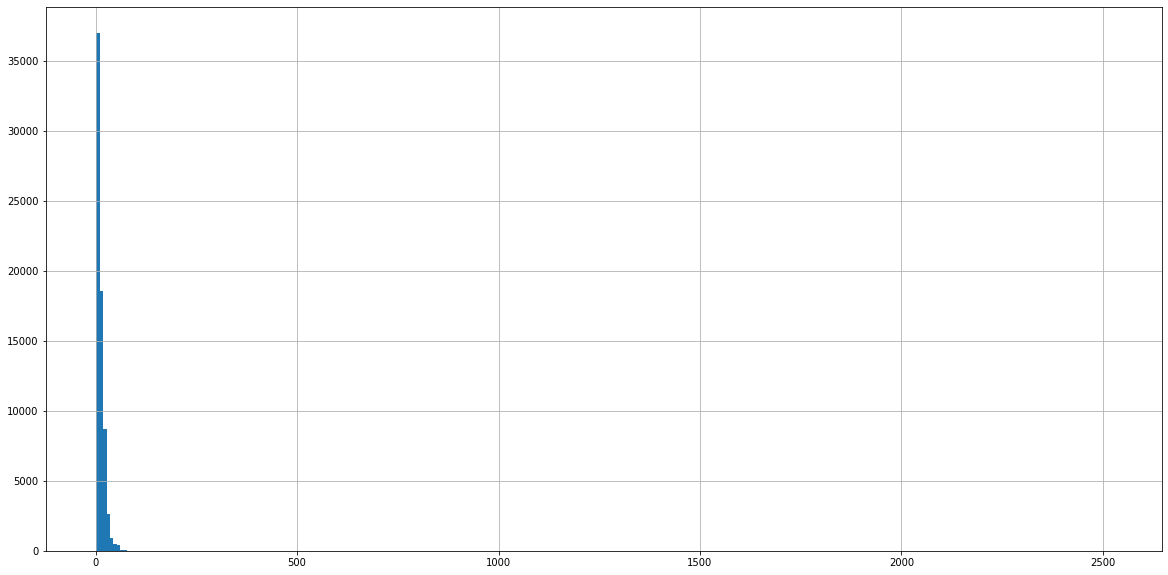

In [ ]:
merged.text.str.split().apply(lambda x: len(x)).hist(bins=300)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    'DeepPavlov/rubert-base-cased'
    #do_lower_case=True
)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    list(merged.loc[X_train, 'text'].values), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    max_length=70, 
    return_tensors='pt',
    truncation=True
)

encoded_data_val = tokenizer.batch_encode_plus(
    list(merged.loc[X_val, 'text'].values), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    max_length=70, 
    return_tensors='pt',
    truncation=True
)

In [ ]:
with open(
    'drive/MyDrive/data/whole_text/encoded_data_train.pickle', 'wb'
) as f:
  pickle.dump(encoded_data_train, f)

with open(
    'drive/MyDrive/data/whole_text/encoded_data_val.pickle', 'wb'
) as f:
  pickle.dump(encoded_data_val, f)

# Building the model

In [ ]:
with open(
    'drive/MyDrive/data/whole_text/encoded_data_train.pickle', 'rb'
) as f:
  encoded_data_train = pickle.load(f)

with open(
    'drive/MyDrive/data/whole_text/encoded_data_val.pickle', 'rb'
) as f:
  encoded_data_val = pickle.load(f)

In [ ]:
y_train = np.loadtxt('drive/MyDrive/data/whole_text/y_train.txt')
y_val = np.loadtxt('drive/MyDrive/data/whole_text/y_val.txt')

In [ ]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train, dtype=torch.long)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_val, dtype=torch.long)

In [ ]:
dataset_train = TensorDataset(
    input_ids_train, attention_masks_train, labels_train
)
dataset_val = TensorDataset(
    input_ids_val, attention_masks_val, labels_val
)

In [ ]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
device

device(type='cuda')

In [ ]:
#ЗАМЕНИЛ МОДЕЛЬ!

model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=len(label_dict),
    output_attentions=False,
    output_hidden_states=False
)

model.to(device)

'''model.load_state_dict(
    torch.load('drive/MyDrive/models/finetuned_BERT_epoch_27.model', 
    map_location=torch.device('cpu'))
)'''

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

"model.load_state_dict(\n    torch.load('drive/MyDrive/models/finetuned_BERT_epoch_27.model', \n    map_location=torch.device('cpu'))\n)"

In [ ]:
batch_size = 64

dataloader_train = DataLoader(
    dataset_train, 
    sampler=RandomSampler(dataset_train), 
    batch_size=batch_size
)

dataloader_validation = DataLoader(
    dataset_val, 
    sampler=SequentialSampler(dataset_val), 
    batch_size=batch_size
)

In [ ]:
optimizer = AdamW(
    model.parameters(),
    lr=1e-5, 
    eps=1e-8
)
                  
epochs = 100

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train)*epochs
)

#Training loop


In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(
        dataloader_train, 
        desc='Epoch {:1d}'.format(epoch), 
        leave=False, 
        disable=False
    )
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix(
            {'training_loss': '{:.3f}'.format(loss.item()/len(batch))}
        )
         
        
    torch.save(
        model.state_dict(), 
        f'drive/MyDrive/models/finetuned_BERT_epoch_{epoch}.model'
    )
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


Epoch 1
Training loss: 0.8188731278551376
Validation loss: 0.7776311834653219
F1 Score (Weighted): 0.509848826449949



Epoch 2
Training loss: 0.7732724283501828
Validation loss: 0.763931879290828
F1 Score (Weighted): 0.5413589291189542



Epoch 3
Training loss: 0.7564621992155495
Validation loss: 0.7634454689644001
F1 Score (Weighted): 0.5505945578005467



Epoch 4
Training loss: 0.7365150142257305
Validation loss: 0.7687712720146885
F1 Score (Weighted): 0.5479900440594951



Epoch 5
Training loss: 0.7158223259559726
Validation loss: 0.7832628416794317
F1 Score (Weighted): 0.5834713235208268



Epoch 6
Training loss: 0.6911852257047522
Validation loss: 0.8306544594190739
F1 Score (Weighted): 0.5277512641558583



Epoch 7
Training loss: 0.6670256298577454
Validation loss: 0.8184434009922875
F1 Score (Weighted): 0.5434814301363493



Epoch 8
Training loss: 0.6408218397567639
Validation loss: 0.8651286832712315
F1 Score (Weighted): 0.5611676149675896



Epoch 9
Training loss: 0.6157763979567832
Validation loss: 0.9109933895093424
F1 Score (Weighted): 0.5617803018061148



Epoch 10
Training loss: 0.588967190899716
Validation loss: 0.9184915141926872
F1 Score (Weighted): 0.5359682857274648



Epoch 11
Training loss: 0.5725189708826834
Validation loss: 0.987528888715638
F1 Score (Weighted): 0.5649041663775234



Epoch 12
Training loss: 0.5497718529373992
Validation loss: 1.0260157027730235
F1 Score (Weighted): 0.5518398766733108



Epoch 13
Training loss: 0.5285496040948036
Validation loss: 1.0748639984263315
F1 Score (Weighted): 0.5679602052861686



Epoch 14
Training loss: 0.509327547253716
Validation loss: 1.1667915808933753
F1 Score (Weighted): 0.5414844109471679



Epoch 15
Training loss: 0.49273341337470694
Validation loss: 1.2069697898847085
F1 Score (Weighted): 0.5662509102546094



Epoch 16
Training loss: 0.47451752291990384
Validation loss: 1.199528995487425
F1 Score (Weighted): 0.5683638109609679



Epoch 17
Training loss: 0.44977513741475017
Validation loss: 1.2743278465889119
F1 Score (Weighted): 0.5643725682217149



Epoch 18
Training loss: 0.42889207038717003
Validation loss: 1.3097088110667687
F1 Score (Weighted): 0.5577863891116012



Epoch 19
Training loss: 0.41059099800569476
Validation loss: 1.3288962769287604
F1 Score (Weighted): 0.5562864403145722



Epoch 20
Training loss: 0.3890445270067152
Validation loss: 1.33821345810537
F1 Score (Weighted): 0.5686554774063112



Epoch 21
Training loss: 0.3695187372904198
Validation loss: 1.4621559574648186
F1 Score (Weighted): 0.5544122394004166



Epoch 22
Training loss: 0.3466399276957792
Validation loss: 1.4617060831299535
F1 Score (Weighted): 0.556735517402412


Buffered data was truncated after reaching the output size limit.